<a href="https://colab.research.google.com/github/achakraborty2024/Cinema-Analysis-Prediction-System/blob/movie_recommendation_module/Capstone_Project_NLP_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Section - Movies recommendation system (Capstone project)

### Responsible team member: Rene Ortiz

In [ ]:
#!pip install ydata-profiling

In [ ]:
import pandas as pd
import numpy as np

#EDA Profiling library
#from ydata_profiling import ProfileReport

In [ ]:
# load movie dataset from Google Drive using pandas

from google.colab import drive
drive.mount('/content/drive')

# Load CSV file
df = pd.read_csv('/content/drive/MyDrive/Capstone_Project/movies.csv')

df.head(3)

Mounted at /content/drive


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466


In [ ]:
df.dtypes

,0
budget,int64
genres,object
homepage,object
id,int64
keywords,object
original_language,object
original_title,object
overview,object
popularity,float64
production_companies,object


In [ ]:
# I created this function after the initial trainings as I realized a json string is not a good strategy, JSON needs to be parse for better results
import ast

# clean function for genre and keyword fields
def extract_names(json_str):
    try:
        items = ast.literal_eval(json_str)
        return " ".join([item['name'] for item in items if 'name' in item])
    except (ValueError, SyntaxError):
        return ""



In [ ]:
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
profile.to_notebook_iframe()

## *Recommendation Models Section :  TF-IDF , BERT and LSTM*

# TERM Frequency-Inverse Document Frequency Recommendation system using the following logic:

- Combining features like genres, keywords, and overview text into a single string for each movie.

- Converting text into vectors using this techniques: TF-IDF (Term Frequency-Inverse Document Frequency) and CountVectorizer.

- Calculating similarity between movies using cosine similarity.

- Returning the top-N most similar movies for a given input movie.

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df_clean = df[['title', 'overview', 'genres', 'keywords', 'popularity', 'release_date']].dropna()

# format JSON strings from genre and keyboards
df_clean['genres'] = df_clean['genres'].apply(extract_names)
df_clean['keywords'] = df_clean['keywords'].apply(extract_names)

# Get the from each
df_text = df_clean[['title', 'overview', 'genres', 'keywords']]
df_text.dropna(inplace=True)


/tmp/ipython-input-23-227816985.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text.dropna(inplace=True)


In [ ]:
df_text.head()

,title,overview,genres,keywords
0,Avatar,"In the 22nd century, a paraplegic Marine is di...",Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...
1,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",Adventure Fantasy Action,ocean drug abuse exotic island east india trad...
2,Spectre,A cryptic message from Bond’s past sends him o...,Action Adventure Crime,spy based on novel secret agent sequel mi6 bri...
3,The Dark Knight Rises,Following the death of District Attorney Harve...,Action Crime Drama Thriller,dc comics crime fighter terrorist secret ident...
4,John Carter,"John Carter is a war-weary, former military ca...",Action Adventure Science Fiction,based on novel mars medallion space travel pri...


In [ ]:
# Combine text into a single feature
def combine_features(row):
    return f"{row['overview']} {row['genres']} {row['keywords']}"

df_text['combined_text'] = df_text.apply(combine_features, axis=1)

/tmp/ipython-input-25-851857547.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text['combined_text'] = df_text.apply(combine_features, axis=1)


In [ ]:
df_text.head()

,title,overview,genres,keywords,combined_text
0,Avatar,"In the 22nd century, a paraplegic Marine is di...",Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...,"In the 22nd century, a paraplegic Marine is di..."
1,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",Adventure Fantasy Action,ocean drug abuse exotic island east india trad...,"Captain Barbossa, long believed to be dead, ha..."
2,Spectre,A cryptic message from Bond’s past sends him o...,Action Adventure Crime,spy based on novel secret agent sequel mi6 bri...,A cryptic message from Bond’s past sends him o...
3,The Dark Knight Rises,Following the death of District Attorney Harve...,Action Crime Drama Thriller,dc comics crime fighter terrorist secret ident...,Following the death of District Attorney Harve...
4,John Carter,"John Carter is a war-weary, former military ca...",Action Adventure Science Fiction,based on novel mars medallion space travel pri...,"John Carter is a war-weary, former military ca..."


In [ ]:
df_text['combined_text'][0]

'In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization. Action Adventure Fantasy Science Fiction culture clash future space war space colony society space travel futuristic romance space alien tribe alien planet cgi marine soldier battle love affair anti war power relations mind and soul 3d'

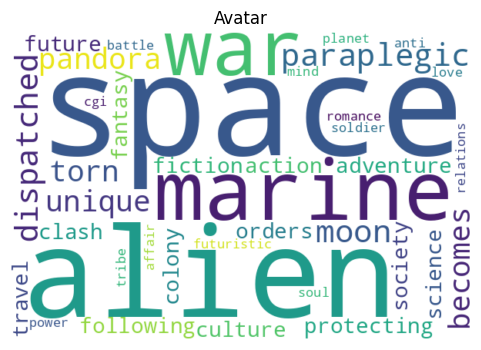

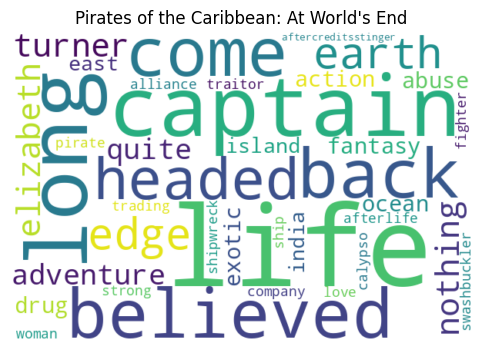

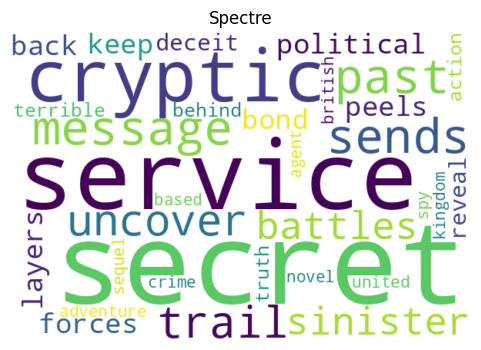

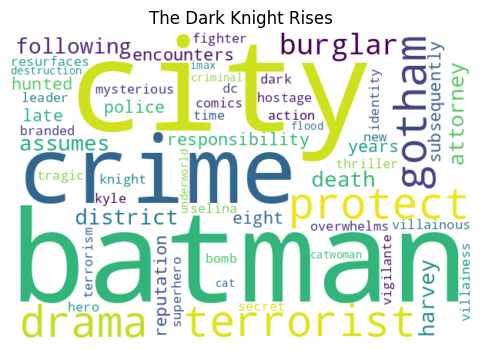

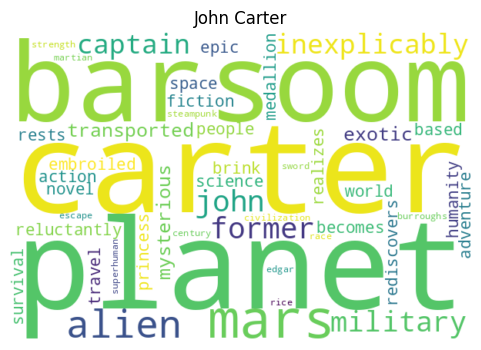

In [ ]:
# Remove stop words and Word Cloud for 5 movies (reference purposes only)
def clean_text(text):
    tokens = text.lower().split()
    return " ".join([word for word in tokens if word not in stop_words and word.isalpha()])

df_text['clean_text'] = df_text['combined_text'].apply(clean_text)

# Generate word cloud for first 5 movies
for i in range(5):
    wc = WordCloud(width=600, height=400, background_color='white').generate(df_text['clean_text'].iloc[i])
    plt.figure(figsize=(6, 4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(df['title'].iloc[i])
    plt.show()

# Clean text to vectors using TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = vectorizer.fit_transform(df_text['clean_text'])

In [ ]:
tfidf_matrix.indices

array([2699, 1279, 2891, ..., 1298, 1332,  617], dtype=int32)

In [ ]:
df_clean.head()

,title,overview,genres,keywords,popularity,release_date
0,Avatar,"In the 22nd century, a paraplegic Marine is di...",Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...,150.437577,2009-12-10
1,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",Adventure Fantasy Action,ocean drug abuse exotic island east india trad...,139.082615,2007-05-19
2,Spectre,A cryptic message from Bond’s past sends him o...,Action Adventure Crime,spy based on novel secret agent sequel mi6 bri...,107.376788,2015-10-26
3,The Dark Knight Rises,Following the death of District Attorney Harve...,Action Crime Drama Thriller,dc comics crime fighter terrorist secret ident...,112.312950,2012-07-16
4,John Carter,"John Carter is a war-weary, former military ca...",Action Adventure Science Fiction,based on novel mars medallion space travel pri...,43.926995,2012-03-07


In [ ]:
df_clean['release_date'] = pd.to_datetime(df_clean['release_date'], errors='coerce').dt.year
df_clean['release_year'] = df_clean['release_date'].fillna(0).astype(int)
df_clean['popularity'] = pd.to_numeric(df_clean['popularity'], errors='coerce').fillna(0)
# metadata: release year and popularity
metadata = df_clean[['release_year', 'popularity']].fillna(0)

In [ ]:
metadata.head()

,release_year,popularity
0,2009,150.437577
1,2007,139.082615
2,2015,107.376788
3,2012,112.312950
4,2012,43.926995


In [ ]:
# normalize the metadata
scaler = MinMaxScaler()
normalized_metadata = scaler.fit_transform(metadata[['release_year', 'popularity']])

In [ ]:
# combine TF-IDF vectors with metadata (This steps needs a GPU otherwise it takes significant time)
tfidf_dense = tfidf_matrix.toarray()

In [ ]:
# stack features
hybrid_features_tfidf = np.hstack([tfidf_dense, normalized_metadata])

In [ ]:
# Compute Cosine Similarity
#cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim = cosine_similarity(hybrid_features_tfidf)

In [ ]:
cosine_sim

array([[1.        , 0.47510747, 0.48491201, ..., 0.47165521, 0.46307268,
        0.44450296],
       [0.47510747, 1.        , 0.48764759, ..., 0.46499235, 0.45806016,
        0.43968479],
       [0.48491201, 0.48764759, 1.        , ..., 0.49289385, 0.48047999,
        0.46117052],
       ...,
       [0.47165521, 0.46499235, 0.49289385, ..., 1.        , 0.48515064,
        0.46441463],
       [0.46307268, 0.45806016, 0.48047999, ..., 0.48515064, 1.        ,
        0.45930899],
       [0.44450296, 0.43968479, 0.46117052, ..., 0.46441463, 0.45930899,
        1.        ]])

In [ ]:
# compute similarity matrix for the hybrid TF-IDF + metadata model
similarity_matrix = cosine_similarity(hybrid_features_tfidf)

# Functions to call recommendations, sim-scores, genre the TMDB API (queryposters and cast)

In [ ]:
import requests
from IPython.display import Image, display

# API key
api_key = "b400409e22d456acb002b98fa90b2c2d" # I got this key by registering on TMDB website

# get poster URL from TMDb
def get_poster_url(movie_title):
    try:
        url = f"https://api.themoviedb.org/3/search/movie?api_key={api_key}&query={movie_title}"
        response = requests.get(url)
        data = response.json()
        if data["results"] and data["results"][0].get("poster_path"):
            poster_path = data["results"][0]["poster_path"]
            return f"https://image.tmdb.org/t/p/w300{poster_path}"
    except Exception as e:
        print(f"Error fetching poster for {movie_title}: {e}")
    return None

In [ ]:
# Recommendation function with poster display
def recommend_movies(title, top_n=5):
    idx = df_clean[df_clean['title'].str.lower() == title.lower()].index
    if len(idx) == 0:
        print("Movie not found.")
        return

    idx = idx[0]
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    movie_indices = [i[0] for i in sim_scores]

    recommendations = df_clean[['title', 'genres', 'keywords', 'overview']].iloc[movie_indices].copy()
    recommendations['similarity_score'] = [sim[1] for sim in sim_scores]

    # Display posters and details
    for _, row in recommendations.iterrows():
        title = row['title']
        poster_url = get_poster_url(title)
        print(f"\n {title} (Similarity Score: {row['similarity_score']:.3f})")
        print(f"Genres: {row['genres']}")
        print(f"Keywords: {row['keywords']}")
        if poster_url:
            display(Image(url=poster_url))
        else:
            print("Poster not found.")

    return recommendations.sort_values(by='similarity_score', ascending=False)

In [ ]:
def explain_recommendation(input_title, recommended_df):
    input_row = df_clean[df_clean['title'].str.lower() == input_title.lower()].iloc[0]
    input_genres = set(input_row['genres'].split(','))
    input_keywords = set(input_row['keywords'].split(','))

    explanations = []

    for _, row in recommended_df.iterrows():
        rec_genres = set(row['genres'].split(','))
        rec_keywords = set(row['keywords'].split(','))
        common_genres = input_genres.intersection(rec_genres)
        common_keywords = input_keywords.intersection(rec_keywords)

        explanation = {
            'title': row['title'],
            'similarity_score': row['similarity_score'],
            'shared_genres': ', '.join(common_genres),
            'shared_keywords': ', '.join(common_keywords)
        }
        explanations.append(explanation)

    return pd.DataFrame(explanations)


In [ ]:
recs = recommend_movies("Superman", top_n=5)
explanations = explain_recommendation("Superman", recs)
display(explanations)


 Superman Returns (Similarity Score: 0.593)
Genres: Adventure Fantasy Action Science Fiction
Keywords: saving the world dc comics invulnerability sequel superhero based on comic book kryptonite super powers superhuman strength lex luthor



 Man of Steel (Similarity Score: 0.569)
Genres: Action Adventure Fantasy Science Fiction
Keywords: saving the world dc comics superhero based on comic book superhuman alien invasion reboot super powers dc extended universe



 X-Men: Apocalypse (Similarity Score: 0.550)
Genres: Science Fiction
Keywords: mutant supernatural powers marvel comic superhero based on comic book superhuman apocalypse superhero team world domination aftercreditsstinger 1980s



 Superman IV: The Quest for Peace (Similarity Score: 0.541)
Genres: Action Adventure Science Fiction
Keywords: saving the world dc comics mountains nuclear missile u.s. army alter ego sequel superhero laboratory convertible catholic school newspaper editor nuclear weapons disarmament volcanic eruption great wall of china super powers superhuman strength



 Batman v Superman: Dawn of Justice (Similarity Score: 0.540)
Genres: Action Adventure Fantasy
Keywords: dc comics vigilante superhero based on comic book revenge super powers clark kent bruce wayne dc extended universe


,title,similarity_score,shared_genres,shared_keywords
0,Superman Returns,0.593078,,
1,Man of Steel,0.568557,Action Adventure Fantasy Science Fiction,
2,X-Men: Apocalypse,0.549582,,
3,Superman IV: The Quest for Peace,0.540714,,
4,Batman v Superman: Dawn of Justice,0.540101,,


# Movie Clustering

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(df_text['combined_text'])

In [ ]:
num_clusters = 5  # We can try less or more depending how we want to present this on the project
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_text['cluster'] = kmeans.fit_predict(X)

In [ ]:
pca = PCA(n_components=2, random_state=42)
reduced = pca.fit_transform(X.toarray())

df_text['pca1'] = reduced[:, 0]
df_text['pca2'] = reduced[:, 1]

/tmp/ipython-input-48-212090144.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_titles = df_text.groupby('cluster').apply(lambda x: x.sample(1, random_state=42))


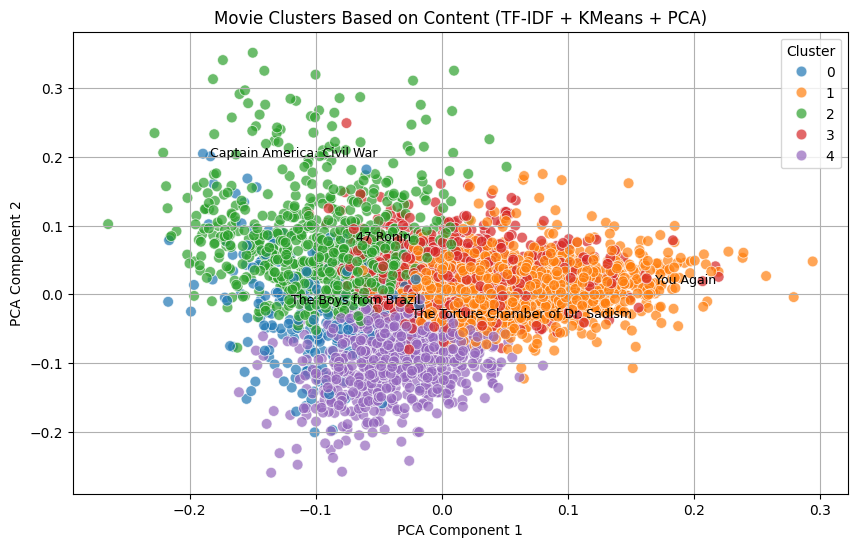

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="pca1", y="pca2", hue="cluster", palette="tab10", data=df_text, s=60, alpha=0.7
)
# For refence, I'm adding labels for some sample movies
sample_titles = df_text.groupby('cluster').apply(lambda x: x.sample(1, random_state=42))
for _, row in sample_titles.iterrows():
    plt.text(row['pca1'], row['pca2'], row['title'], fontsize=9)
plt.title("Movie Clusters Based on Content (TF-IDF + KMeans + PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Re-use your TF-IDF vectorizer
terms = vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

print("\nTop terms per cluster:")
for i in range(num_clusters):
    print(f"\nCluster {i}:")
    for j in range(10):
        print(f"  {terms[order_centroids[i, j]]}")


Top terms per cluster:

Cluster 0:
  secret
  agent
  action
  thriller
  cia
  comic
  spy
  superhero
  adventure
  fbi

Cluster 1:
  comedy
  drama
  romance
  love
  film
  life
  woman
  school
  new
  music

Cluster 2:
  war
  science
  fiction
  action
  world
  space
  alien
  adventure
  thriller
  dystopia

Cluster 3:
  family
  father
  comedy
  adventure
  animation
  fantasy
  son
  relationship
  drama
  young

Cluster 4:
  crime
  thriller
  murder
  police
  action
  drama
  drug
  mystery
  killer
  horror


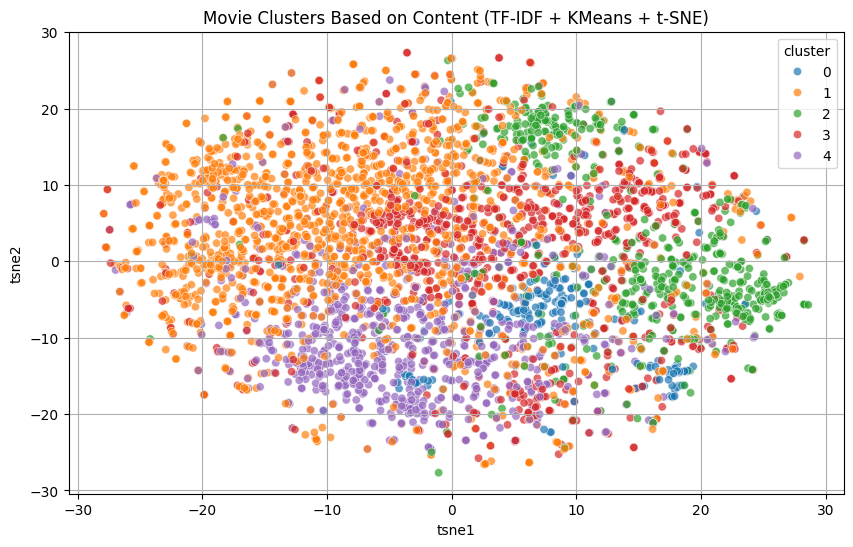

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=50, n_iter=300, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

df_text['tsne1'], df_text['tsne2'] = X_embedded[:,0], X_embedded[:,1]

# Plot with t-SNE
plt.figure(figsize=(10,6))
sns.scatterplot(x='tsne1', y='tsne2', hue='cluster', data=df_text, palette='tab10', alpha=0.7)
plt.title("Movie Clusters Based on Content (TF-IDF + KMeans + t-SNE)")
plt.grid(True)
plt.show()


# Hybrid Approach - BERT

This next section will combine multiple text and numeric features:

- Textual features (overview, keywords)

- Metadata (genre, release year, cast)

- Ratings / popularity scores

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
df_clean = df[['title', 'overview', 'genres', 'keywords', 'popularity', 'release_date']].dropna()

# format JSON strings from genre and keyboards
df_clean['genres'] = df_clean['genres'].apply(extract_names)
df_clean['keywords'] = df_clean['keywords'].apply(extract_names)

# Get the from each
df_text = df_clean[['title', 'overview', 'genres', 'keywords']]
df_text.dropna(inplace=True)


In [ ]:
df_clean.head()

,title,overview,genres,keywords,popularity,release_date,combined_text,release_year
0,Avatar,"In the 22nd century, a paraplegic Marine is di...",Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...,150.437577,2009,"In the 22nd century, a paraplegic Marine is di...",2009
1,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",Adventure Fantasy Action,ocean drug abuse exotic island east india trad...,139.082615,2007,"Captain Barbossa, long believed to be dead, ha...",2007
2,Spectre,A cryptic message from Bond’s past sends him o...,Action Adventure Crime,spy based on novel secret agent sequel mi6 bri...,107.376788,2015,A cryptic message from Bond’s past sends him o...,2015
3,The Dark Knight Rises,Following the death of District Attorney Harve...,Action Crime Drama Thriller,dc comics crime fighter terrorist secret ident...,112.312950,2012,Following the death of District Attorney Harve...,2012
4,John Carter,"John Carter is a war-weary, former military ca...",Action Adventure Science Fiction,based on novel mars medallion space travel pri...,43.926995,2012,"John Carter is a war-weary, former military ca...",2012


In [ ]:
# text fields for BERT input
df_clean['combined_text'] = df['overview'] + " " + df['genres'] + " " + df['keywords']

# release date to year
#df_clean['release_date'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year.fillna(0).astype(int)
df_clean['release_date'] = pd.to_datetime(df_clean['release_date'], errors='coerce').dt.year
df_clean['release_year'] = df_clean['release_date'].fillna(0).astype(int)
df_clean['popularity'] = pd.to_numeric(df_clean['popularity'], errors='coerce').fillna(0)
# metadata: release year and popularity
metadata = df_clean[['release_year', 'popularity']].fillna(0)

In [ ]:
# load BERT model
model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Due to previous errors, I will replace NaN or non-string values with an empty string
df_clean['combined_text'] = df_clean['combined_text'].fillna('').astype(str)
# encode combined text
bert_embeddings = model.encode(df_clean['combined_text'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
# movies numerical metadata
#metadata = df_clean[['release_date', 'popularity']].fillna(0)

# normalize
scaler = MinMaxScaler()
normalized_metadata = scaler.fit_transform(metadata)

# BERT + Metadata
hybrid_features = np.hstack([bert_embeddings, normalized_metadata])

In [ ]:
# computer similirity cosine
similarity_matrix = cosine_similarity(hybrid_features)

In [ ]:
# updated recommendation movies w/ similarity scores, genre and keywords
def recommend_movies(title, top_n=10):
    idx = df_clean[df_clean['title'].str.lower() == title.lower()].index
    if len(idx) == 0:
        print("Movie not found.")
        return

    idx = idx[0]
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    movie_indices = [i[0] for i in sim_scores]

    recommendations = df_clean[['title', 'release_year', 'genres', 'keywords', 'overview']].iloc[movie_indices].copy()
    recommendations['similarity_score'] = [sim[1] for sim in sim_scores]

    for _, row in recommendations.iterrows():
        movie_title = row['title']
        release_year = row['release_year']
        print(f"\n {movie_title} ({release_year}) — Similarity Score: {row['similarity_score']:.3f}")
        print(f"Genres: {row['genres']}")
        print(f"Keywords: {row['keywords']}")
        poster_url = get_poster_url(movie_title)
        if poster_url:
            display(Image(url=poster_url))
        else:
            print("Poster not found.")
        print("-" * 60)

    return recommendations.sort_values(by='similarity_score', ascending=False)

In [ ]:
import requests
from IPython.display import Image, display

# API key
api_key = "b400409e22d456acb002b98fa90b2c2d" # I got this key by registering on TMDB website

# get poster URL from TMDb
def get_poster_url(movie_title):
    try:
        url = f"https://api.themoviedb.org/3/search/movie?api_key={api_key}&query={movie_title}"
        response = requests.get(url)
        data = response.json()
        if data["results"] and data["results"][0].get("poster_path"):
            poster_path = data["results"][0]["poster_path"]
            return f"https://image.tmdb.org/t/p/w300{poster_path}"
    except Exception as e:
        print(f"Error fetching poster for {movie_title}: {e}")
    return None

In [ ]:
recommend_movies("Toy Story", top_n=5)


 Toy Story 3 (2010) — Similarity Score: 0.935
Genres: Animation Family Comedy
Keywords: hostage college toy barbie animation escape day care teddy bear duringcreditsstinger toy comes to life personification inanimate objects coming to life toy story


------------------------------------------------------------

 Toy Story 2 (1999) — Similarity Score: 0.928
Genres: Animation Comedy Family
Keywords: museum prosecution identity crisis airplane flea market collector teamwork friendship rescue team garage sale duringcreditsstinger toy comes to life personification inanimate objects coming to life


------------------------------------------------------------

 CJ7 (2008) — Similarity Score: 0.898
Genres: Comedy Drama Family Fantasy Science Fiction
Keywords: little boy ufo extraterrestrial


------------------------------------------------------------

 Rushmore (1998) — Similarity Score: 0.878
Genres: Comedy Drama
Keywords: private school lone wolf theatre play theatre group theatre director independent film


------------------------------------------------------------

 Jimmy Neutron: Boy Genius (2001) — Similarity Score: 0.878
Genres: Action Adventure Animation Comedy Family Fantasy Science Fiction
Keywords: showdown gi villain genius alien rescue miniaturization robot battle laser gun spear boy genius


------------------------------------------------------------


,title,release_year,genres,keywords,overview,similarity_score
42,Toy Story 3,2010,Animation Family Comedy,hostage college toy barbie animation escape da...,"Woody, Buzz, and the rest of Andy's toys haven...",0.935133
343,Toy Story 2,1999,Animation Comedy Family,museum prosecution identity crisis airplane fl...,"Andy heads off to Cowboy Camp, leaving his toy...",0.928273
2262,CJ7,2008,Comedy Drama Family Fantasy Science Fiction,little boy ufo extraterrestrial,"Ti, a really poor construction worker that str...",0.897503
3023,Rushmore,1998,Comedy Drama,private school lone wolf theatre play theatre ...,When a beautiful first-grade teacher arrives a...,0.878488
1825,Jimmy Neutron: Boy Genius,2001,Action Adventure Animation Comedy Family Fanta...,showdown gi villain genius alien rescue miniat...,Jimmy Neutron is a boy genius and way ahead of...,0.878079


# K-meamns clustering for Bert recommendation system

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(bert_embeddings)

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(bert_embeddings)
df['pca1'] = pca_result[:, 0]
df['pca2'] = pca_result[:, 1]

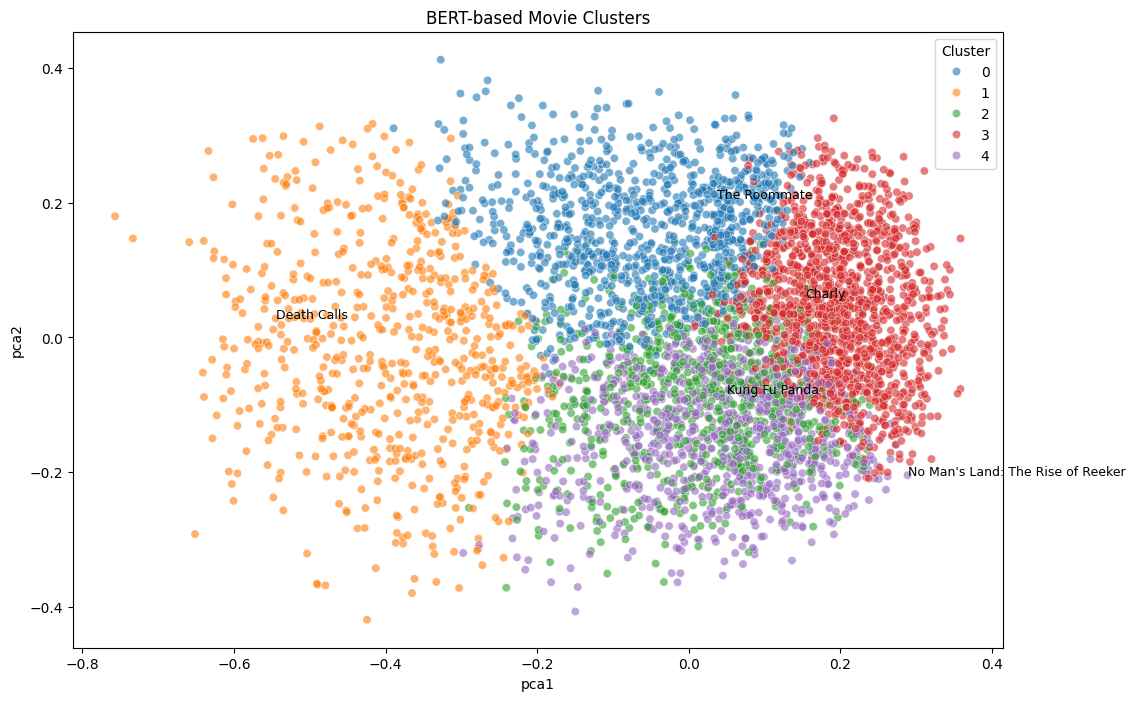

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', palette='tab10', alpha=0.6)

# Add labels for a few example movies (1 per cluster)
sample_titles = df.groupby('cluster').apply(lambda x: x.sample(1, random_state=11)).reset_index(drop=True)
for _, row in sample_titles.iterrows():
    plt.text(row['pca1'], row['pca2'], row['title'], fontsize=9)

plt.title("BERT-based Movie Clusters")
plt.legend(title='Cluster')
plt.show()

In [ ]:
print("\nTop representative movies per BERT-based cluster:")
for i in range(n_clusters):
    print(f"\nCluster {i}:")

    # get indices of items in this cluster
    cluster_indices = df[df['cluster'] == i].index

    # get the centroid of the cluster
    centroid = kmeans.cluster_centers_[i].reshape(1, -1)

    # compute cosine similarity to the centroid
    cluster_embeddings = bert_embeddings[cluster_indices]
    sims = cosine_similarity(cluster_embeddings, centroid).flatten()

    # get top 5 most representative movies
    top_indices = cluster_indices[np.argsort(sims)[-5:][::-1]]
    for idx in top_indices:
        print(f"  {df.loc[idx, 'title']} - {df.loc[idx, 'genres']}")



Top representative movies per BERT-based cluster:

Cluster 0:
  Stepmom - [{"id": 18, "name": "Drama"}, {"id": 10749, "name": "Romance"}]
  Submarine - [{"id": 18, "name": "Drama"}, {"id": 35, "name": "Comedy"}, {"id": 10749, "name": "Romance"}]
  To Die For - [{"id": 14, "name": "Fantasy"}, {"id": 18, "name": "Drama"}, {"id": 35, "name": "Comedy"}, {"id": 53, "name": "Thriller"}]
  Somewhere - [{"id": 35, "name": "Comedy"}, {"id": 18, "name": "Drama"}]
  Down to You - [{"id": 35, "name": "Comedy"}, {"id": 18, "name": "Drama"}, {"id": 10751, "name": "Family"}, {"id": 10749, "name": "Romance"}]

Cluster 1:
  Kung Pow: Enter the Fist - [{"id": 28, "name": "Action"}, {"id": 35, "name": "Comedy"}]
  An Alan Smithee Film: Burn, Hollywood, Burn - [{"id": 35, "name": "Comedy"}]
  The Black Dahlia - [{"id": 18, "name": "Drama"}]
  Movie 43 - [{"id": 35, "name": "Comedy"}]
  Sympathy for Lady Vengeance - [{"id": 18, "name": "Drama"}, {"id": 53, "name": "Thriller"}]

Cluster 2:
  I, Frankenstei

# Unsupervised LSTM Model (recommendation system).

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Load dataframe (df) from google drive running the top cells

# clean and combine text features as with TF-IDF and BERT
df_clean = df[['title', 'overview', 'genres', 'keywords', 'popularity', 'release_date']].dropna()

# combine text fields into one
df_clean['combined_text'] = df_clean['title'] + " " + df_clean['overview'] + " " + df_clean['genres'] + " " + df_clean['keywords']

# normalize popularity and release date
df_clean['release_date'] = pd.to_datetime(df_clean['release_date'], errors='coerce').dt.year.fillna(0).astype(int)
scaler = MinMaxScaler()
df_clean[['popularity', 'release_date']] = scaler.fit_transform(df_clean[['popularity', 'release_date']])



In [ ]:
# example of combined_text for reference purposes
df_clean['combined_text'][1]

'Pirates of the Caribbean: At World\'s End Captain Barbossa, long believed to be dead, has come back to life and is headed to the edge of the Earth with Will Turner and Elizabeth Swann. But nothing is quite as it seems. [{"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 28, "name": "Action"}] [{"id": 270, "name": "ocean"}, {"id": 726, "name": "drug abuse"}, {"id": 911, "name": "exotic island"}, {"id": 1319, "name": "east india trading company"}, {"id": 2038, "name": "love of one\'s life"}, {"id": 2052, "name": "traitor"}, {"id": 2580, "name": "shipwreck"}, {"id": 2660, "name": "strong woman"}, {"id": 3799, "name": "ship"}, {"id": 5740, "name": "alliance"}, {"id": 5941, "name": "calypso"}, {"id": 6155, "name": "afterlife"}, {"id": 6211, "name": "fighter"}, {"id": 12988, "name": "pirate"}, {"id": 157186, "name": "swashbuckler"}, {"id": 179430, "name": "aftercreditsstinger"}]'

In [ ]:
df_clean.head()

,title,overview,genres,keywords,popularity,release_date,combined_text
0,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",0.171814,0.920792,"Avatar In the 22nd century, a paraplegic Marin..."
1,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",0.158846,0.900990,Pirates of the Caribbean: At World's End Capta...
2,Spectre,A cryptic message from Bond’s past sends him o...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",0.122634,0.980198,Spectre A cryptic message from Bond’s past sen...
3,The Dark Knight Rises,Following the death of District Attorney Harve...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",0.128272,0.950495,The Dark Knight Rises Following the death of D...
4,John Carter,"John Carter is a war-weary, former military ca...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",0.050169,0.950495,"John Carter John Carter is a war-weary, former..."


In [ ]:
# format JSON strings from genre and keyboards
df_clean['genres'] = df_clean['genres'].apply(extract_names)
df_clean['keywords'] = df_clean['keywords'].apply(extract_names)

In [ ]:
df_clean.head()

,title,overview,genres,keywords,popularity,release_date,combined_text
0,Avatar,"In the 22nd century, a paraplegic Marine is di...",Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...,0.171814,0.920792,"Avatar In the 22nd century, a paraplegic Marin..."
1,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",Adventure Fantasy Action,ocean drug abuse exotic island east india trad...,0.158846,0.900990,Pirates of the Caribbean: At World's End Capta...
2,Spectre,A cryptic message from Bond’s past sends him o...,Action Adventure Crime,spy based on novel secret agent sequel mi6 bri...,0.122634,0.980198,Spectre A cryptic message from Bond’s past sen...
3,The Dark Knight Rises,Following the death of District Attorney Harve...,Action Crime Drama Thriller,dc comics crime fighter terrorist secret ident...,0.128272,0.950495,The Dark Knight Rises Following the death of D...
4,John Carter,"John Carter is a war-weary, former military ca...",Action Adventure Science Fiction,based on novel mars medallion space travel pri...,0.050169,0.950495,"John Carter John Carter is a war-weary, former..."


In [ ]:
# text preprocessing and tokenization
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_clean['combined_text'])

sequences = tokenizer.texts_to_sequences(df_clean['combined_text'])
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

# metadata as additional input
metadata_features = df_clean[['popularity', 'release_date']].values

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate

# inputs for the model
text_input = Input(shape=(100,), name="text_input")
meta_input = Input(shape=(2,), name="meta_input")

# LSTM on text
embedding = Embedding(input_dim=10000, output_dim=64, input_length=100)(text_input)
lstm_out = LSTM(64)(embedding)

# combine LSTM and metadata
merged = Concatenate()([lstm_out, meta_input])
dense = Dense(64, activation='relu')(merged)
output = Dense(32, activation='relu')(dense)  # This becomes the embedding vector for recommendations

# define model
model = Model(inputs=[text_input, meta_input], outputs=output)
model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 100, 64)   │    640,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     33,024 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_input          │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 66)        │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ meta_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      4,288 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 679,392 (2.59 MB)

 Trainable params: 679,392 (2.59 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# dummy output to learn identity (FYI each movie vector is like a label)
X_text = padded_sequences
X_meta = metadata_features

# random targets for training embeddings
y = np.random.rand(len(df_clean), 32)

# train the model
model.fit([X_text, X_meta], y, epochs=100, batch_size=32)

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.1109
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 0.1067
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - loss: 0.1059
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - loss: 0.1051
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 0.1044
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.1022
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 0.0927
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 0.0899
Epoch 9/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0802
Epoch 10/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - loss: 0.0781
Epoch 11/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 0.0750
Epoch 12/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0657
Epoch 13/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - loss: 0.0629
Epoch 14/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 0.0606
Epoch 15/100
150/150 ━━

In [ ]:
# Get learned embeddings for all movies
movie_embeddings = model.predict([X_text, X_meta])

from sklearn.metrics.pairwise import cosine_similarity

def recommend_lstm(movie_title, top_n=5):
    idx = df_clean[df_clean['title'].str.lower() == movie_title.lower()].index
    if len(idx) == 0:
        print("Movie not found.")
        return

    idx = idx[0]
    query_embedding = movie_embeddings[idx]
    sim_scores = cosine_similarity([query_embedding], movie_embeddings)[0]
    top_indices = np.argsort(sim_scores)[::-1][1:top_n+1]

    recommendations = df_clean.iloc[top_indices][['title', 'genres', 'keywords', 'overview']].copy()
    recommendations['similarity_score'] = sim_scores[top_indices]

    return recommendations.sort_values(by='similarity_score', ascending=False)

150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


In [ ]:
recommend_lstm("Superman")

,title,genres,keywords,overview,similarity_score
79,Iron Man 2,Adventure Action Science Fiction,malibu marvel comic superhero based on comic b...,With the world now aware of his dual life as t...,0.926549
987,Dream House,Drama Thriller Mystery,house fire extension ladder last day on job,"Publisher, Will Atenton quits a lucrative job ...",0.918319
3356,Flirting with Disaster,Comedy Romance,lsd looking for birth parents half-brother in...,"Adopted as a child, new father Mel Colpin (Ben...",0.899952
3716,Lilya 4-ever,Crime Drama,suicide sex sweden underground nightclub nudit...,Lilya lives in poverty and dreams of a better ...,0.897716
1473,The Astronaut's Wife,Drama Science Fiction Thriller,wife husband relationship space travel space m...,When astronaut Spencer Armacost returns to Ear...,0.891503


# GLOVE + LSTM Model w/ additional numeric features (Supervised training)

## 1st load the df from the top df code / google drive

In [ ]:
import re
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# combine text fields
df['combined_text'] = df['overview'].fillna('') + " " + \
                      df['genres'].fillna('') + " " + \
                      df['keywords'].fillna('')

In [ ]:
# function to clean text
def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text.lower()

#apply to the combined text
df['combined_text'] = df['combined_text'].apply(clean_text)

In [ ]:
#  text tokenize
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['combined_text'])
sequences = tokenizer.texts_to_sequences(df['combined_text'])
X_text = pad_sequences(sequences, maxlen=300)

In [ ]:
# normalizing all nmerical features
df['release_year'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year.fillna(0).astype(int)
df[['popularity', 'vote_average', 'vote_count', 'runtime']] = df[['popularity', 'vote_average', 'vote_count', 'runtime']].fillna(0)
numerical = df[['release_year', 'popularity', 'vote_average', 'vote_count', 'runtime']]
scaler = MinMaxScaler()
X_num = scaler.fit_transform(numerical)

In [ ]:
# language encoding
df['original_language'] = df['original_language'].fillna('unknown')
le = LabelEncoder()
X_lang = le.fit_transform(df['original_language']).reshape(-1, 1)

# numerical + language
X_meta = np.hstack((X_num, X_lang))

# input for LSTM
X_final = [X_text, X_meta]

In [ ]:
X_final

[array([[   0,    0,    0, ...,  407,    1,  346],
        [   0,    0,    0, ...,  223,    1,  224],
        [   0,    0,    0, ...,    1,  508,  868],
        ...,
        [   0,    0,    0, ...,    2,    1, 1046],
        [   0,    0,    0, ..., 1555,   25, 4935],
        [   0,    0,    0, ...,    1,  298,  130]], dtype=int32),
 array([[9.96033713e-01, 1.71814515e-01, 7.20000000e-01, 8.58057010e-01,
         4.79289941e-01, 7.00000000e+00],
        [9.95042142e-01, 1.58846031e-01, 6.90000000e-01, 3.27225131e-01,
         5.00000000e-01, 7.00000000e+00],
        [9.99008428e-01, 1.22634857e-01, 6.30000000e-01, 3.24752763e-01,
         4.37869822e-01, 7.00000000e+00],
        ...,
        [9.98016857e-01, 1.64973372e-03, 7.00000000e-01, 4.36300175e-04,
         3.55029586e-01, 7.00000000e+00],
        [9.97521071e-01, 9.78787458e-04, 5.70000000e-01, 5.09016870e-04,
         2.89940828e-01, 7.00000000e+00],
        [9.94050570e-01, 2.20411627e-03, 6.30000000e-01, 1.16346713e-03,
     

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# similarity scores based on vote average
vote_scores = df['vote_average'].values.reshape(-1, 1)
y_similarity = cosine_similarity(vote_scores)

In [ ]:
# download GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d /content/

--2025-07-13 00:26:47--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-07-13 00:26:47--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-07-13 00:26:47--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
# Glove embedding
embedding_index = {}
with open('/content/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((10000, embedding_dim))

for word, i in word_index.items():
    if i >= 10000:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout

# text input
text_input = Input(shape=(300,))
embed = Embedding(input_dim=10000, output_dim=100, weights=[embedding_matrix], input_length=300, trainable=False)(text_input)
lstm_out = LSTM(64)(embed)

# metadata input
meta_input = Input(shape=(X_meta.shape[1],))
meta_dense = Dense(32, activation='relu')(meta_input)

# combine
combined = Concatenate()([lstm_out, meta_dense])
combined = Dropout(0.3)(combined)
output = Dense(1, activation='sigmoid')(combined)

model = Model(inputs=[text_input, meta_input], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 300, 100)  │  1,000,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     42,240 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        224 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 96)        │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         97 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,042,561 (3.98 MB)

 Trainable params: 42,561 (166.25 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [ ]:
# sample dummy labels (1 if vote_average diff < 0.5 else 0)
labels = np.where(abs(df['vote_average'].values - df['vote_average'].values.mean()) < 0.5, 1, 0)

model.fit(X_final, labels, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.5123 - loss: 0.7565 - val_accuracy: 0.7190 - val_loss: 0.6117
Epoch 2/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5333 - loss: 0.7263 - val_accuracy: 0.6556 - val_loss: 0.6552
Epoch 3/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.5507 - loss: 0.6861 - val_accuracy: 0.6837 - val_loss: 0.6523
Epoch 4/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.5682 - loss: 0.6853 - val_accuracy: 0.5442 - val_loss: 0.6790
Epoch 5/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5869 - loss: 0.6715 - val_accuracy: 0.6961 - val_loss: 0.6286
Epoch 6/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6078 - loss: 0.6592 - val_accuracy: 0.5411 - val_loss: 0.6850
Epoch 7/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6125 - loss: 0.6524 - val_accuracy: 0.5796 - val_loss: 0.6669
Epoch 8/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6093 - loss: 0.6483 - val_acc

In [ ]:
from keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity

# xtract features from the penultimate layer
feature_extractor = Model(inputs=model.input, outputs=model.get_layer(index=-2).output)

# feature embeddings for all movies
movie_embeddings = feature_extractor.predict(X_final, batch_size=32)

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [ ]:
# compute pairwise cosine similarity between all movies
similarity_matrix = cosine_similarity(movie_embeddings)

In [ ]:
def recommend_movies_lstm(title, top_n=5):
    # find movie index
    idx = df[df['title'].str.lower() == title.lower()].index
    if len(idx) == 0:
        print("Movie not found.")
        return
    idx = idx[0]

    # Get similarity scores for the movie
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Skip the movie itself (first match) and select top-N
    sim_scores = sim_scores[1:top_n + 1]
    movie_indices = [i[0] for i in sim_scores]

    print(f"\nTop {top_n} similar movies to: {df.iloc[idx]['title']}")
    for i in movie_indices:
        title = df.iloc[i]['title']
        score = sim_scores[movie_indices.index(i)][1]
        print(f"{title} — Similarity Score: {score:.3f}")

In [ ]:
recommend_movies_lstm("Transformers", top_n=5)


Top 5 similar movies to: Transformers
Spider-Man 2 — Similarity Score: 0.929
Left Behind — Similarity Score: 0.926
Dragonball Evolution — Similarity Score: 0.916
Cars — Similarity Score: 0.914
Dinner for Schmucks — Similarity Score: 0.911


In [ ]:
# Clustering
from sklearn.cluster import KMeans

# cluster into 5 groups
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(movie_embeddings)

In [ ]:
# 5 movies per cluster for inspection
for i in range(num_clusters):
    print(f"\nCluster {i}:")
    sample_movies = df[df['cluster'] == i].sample(5, random_state=42)
    for title in sample_movies['title']:
        print(f"  - {title}")


Cluster 0:
  - Wyatt Earp
  - You've Got Mail
  - 1408
  - Stuart Little
  - Sweet November

Cluster 1:
  - Away We Go
  - 127 Hours
  - Dancer in the Dark
  - Persepolis
  - Queen of the Damned

Cluster 2:
  - Kill Bill: Vol. 1
  - Network
  - The French Connection
  - The Brain That Wouldn't Die
  - Dolphin Tale

Cluster 3:
  - Ramanujan
  - Central Station
  - Dragon Nest: Warriors' Dawn
  - Cries and Whispers
  - Coming Home

Cluster 4:
  - I Don't Know How She Does It
  - Fifty Shades of Grey
  - Frozen River
  - Isn't She Great
  - I Am Love


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

print("\nTop representative movies per LSTM-based cluster:")
for i in range(num_clusters):
    print(f"\nCluster {i}:")

    # Get indices of items in this cluster
    cluster_indices = df[df['cluster'] == i].index

    # Get the centroid of the cluster
    centroid = kmeans.cluster_centers_[i].reshape(1, -1)

    # Compute cosine similarity to the centroid
    cluster_embeddings = movie_embeddings[cluster_indices]
    sims = cosine_similarity(cluster_embeddings, centroid).flatten()

    # Get top 5 most representative movies
    top_indices = cluster_indices[np.argsort(sims)[-5:][::-1]]
    for idx in top_indices:
        print(f"  {df.loc[idx, 'title']} - {df.loc[idx, 'genres']}")


Top representative movies per LSTM-based cluster:

Cluster 0:
  The Brothers Grimm - [{"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 28, "name": "Action"}, {"id": 35, "name": "Comedy"}, {"id": 53, "name": "Thriller"}]
  Cellular - [{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 80, "name": "Crime"}, {"id": 53, "name": "Thriller"}]
  Madagascar: Escape 2 Africa - [{"id": 10751, "name": "Family"}, {"id": 16, "name": "Animation"}]
  Hotel for Dogs - [{"id": 35, "name": "Comedy"}, {"id": 10751, "name": "Family"}]
  The Other Guys - [{"id": 28, "name": "Action"}, {"id": 35, "name": "Comedy"}, {"id": 80, "name": "Crime"}]

Cluster 1:
  Undercover Brother - [{"id": 28, "name": "Action"}, {"id": 35, "name": "Comedy"}]
  Insomnia - [{"id": 80, "name": "Crime"}, {"id": 9648, "name": "Mystery"}, {"id": 53, "name": "Thriller"}]
  Guess Who - [{"id": 35, "name": "Comedy"}, {"id": 10749, "name": "Romance"}]
  Hesher - [{"id": 18, "name": "Drama"}]
  Th

/tmp/ipython-input-36-1686716481.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_titles = df.groupby('cluster').apply(lambda x: x.sample(1, random_state=42))


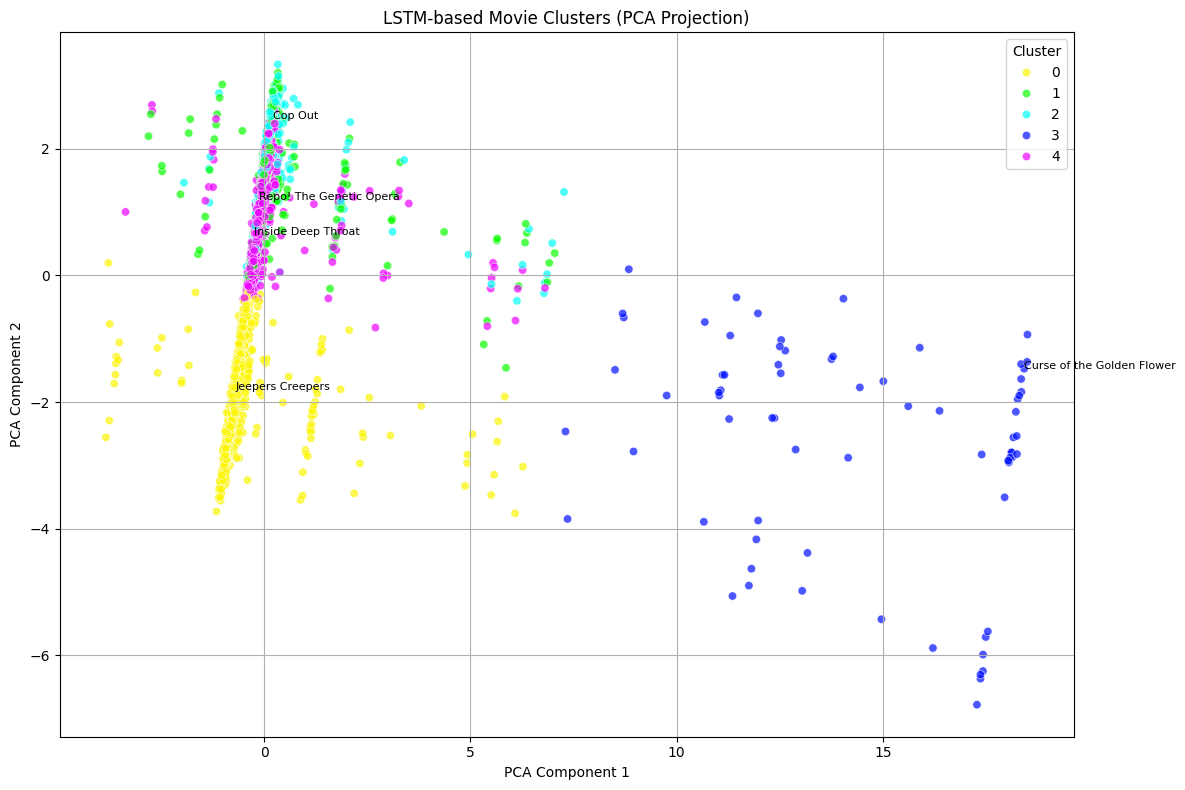

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

# Reduce to 2D using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(movie_embeddings)

# Add PCA components to the DataFrame
df['pca1'] = reduced_embeddings[:, 0]
df['pca2'] = reduced_embeddings[:, 1]
df['cluster'] = kmeans.labels_

# Plot the clusters
plt.figure(figsize=(12, 8))
palette = sns.color_palette("hsv", len(df['cluster'].unique()))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', palette=palette, alpha=0.7)

# Optional: Add movie titles for a few representative samples per cluster
sample_titles = df.groupby('cluster').apply(lambda x: x.sample(1, random_state=42))
for _, row in sample_titles.iterrows():
    plt.text(row['pca1'], row['pca2'], row['title'], fontsize=8)

plt.title("LSTM-based Movie Clusters (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

.